
# How to train, test and tune your model?

## Loading data

In [1]:
from braindecode.datasets import MOABBDataset

subject_id = 3
dataset = MOABBDataset(dataset_name="BNCI2014001", subject_ids=[subject_id])

BNCI2014001 has been renamed to BNCI2014_001. BNCI2014001 will be removed in version 1.1.
The dataset class name 'BNCI2014001' must be an abbreviation of its code 'BNCI2014-001'. See moabb.datasets.base.is_abbrev for more information.


## Preprocessing data

Some of the preprocessing task done here:

- Signal rescaling: from Voltios to microvoltios.
- Bandpass Filtering: Only valid banding is from 4Hz to 38 Hz, everythingf else is eliminated (could be to reduce noise).
- Standardization: Zero mean and 1 variance.

In [8]:
import numpy as np

from braindecode.preprocessing import (
    exponential_moving_standardize,
    preprocess,
    Preprocessor,
)

low_cut_hz = 4.0  # low cut frequency for filtering
high_cut_hz = 38.0  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000

preprocessors = [
    Preprocessor("pick_types", eeg=True, meg=False, stim=False),  # Keep EEG sensors
    Preprocessor(
        lambda data, factor: np.multiply(data, factor),  # Convert from V to uV
        factor=1e6,
    ),
    Preprocessor("filter", l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
    Preprocessor(
        exponential_moving_standardize,  # Exponential moving standardization
        factor_new=factor_new,
        init_block_size=init_block_size,
    ),
]

# Preprocess the data
preprocess(dataset, preprocessors, n_jobs=-1)

/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  22 out of  22 | elaps

## Extraction of the Windows
Extraction of the trials from the times sieries is based on the events inside the dataset. An event is 1) demarcation of the stimulus or 2) beginning of the trial.
We will analyze 0.5 ss *before* the corresponding event and the duration of the event itself.

So, our `trial_start_offset_seconds` is -0.5 s and our `trial_stop_offset_seconds` is 0 s.

In [2]:
from braindecode.preprocessing import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info["sfreq"]
assert all([ds.raw.info["sfreq"] == sfreq for ds in dataset.datasets])
# Calculate the window start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to
# define how windows should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']


## Split dataset

For this data, the splitting is easy as we have to only use the `session` column. For other datasets, it's necesary to evaluate the data.

In [3]:
splitted = windows_dataset.split("session")
train_set = splitted['0train']  # Session train
test_set = splitted['1test']  # Session evaluation

## Create model
In this tutorial, ShallowFBCSPNet classifier is explored.

In [4]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = "cuda" if cuda else "cpu"
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
classes = list(range(n_classes))
# Extract number of chans and time steps from dataset
n_channels = windows_dataset[0][0].shape[0]
input_window_samples = windows_dataset[0][0].shape[1]

model = ShallowFBCSPNet(
    n_channels,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length="auto",
)

# Display torchinfo table describing the model
print(model)

# Send model to GPU
if cuda:
    model.cuda()


Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 26, 1125]             [1, 4]                    --                        --
├─Ensure4d (ensuredims): 1-1             [1, 26, 1125]             [1, 26, 1125, 1]          --                        --
├─Rearrange (dimshuffle): 1-2            [1, 26, 1125, 1]          [1, 1, 1125, 26]          --                        --
├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1125, 26]          [1, 40, 1101, 1]          42,640                    --
├─BatchNorm2d (bnorm): 1-4               [1, 40, 1101, 1]          [1, 40, 1101, 1]          80                        --
├─Expression (conv_nonlin_exp): 1-5      [1, 40, 1101, 1]          [1, 40, 1101, 1]          --                        --
├─AvgPool2d (pool): 1-6                  [1, 40, 1101, 1]          [1, 40, 69, 1]            --                        [75, 1]
├─Express

/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


## How to train and evaluate your model
### 1. Train-test split
You dont create  a validation dataset.

In [5]:
from skorch.callbacks import LRScheduler

from braindecode import EEGClassifier

lr = 0.0625 * 0.01
weight_decay = 0
batch_size = 64
n_epochs = 2

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler("CosineAnnealingLR", T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
    max_epochs=n_epochs,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(train_set, y=None)

# evaluated the model after training
y_test = test_set.get_metadata().target
test_acc = clf.score(test_set, y=y_test)
print(f"Test acc: {(test_acc * 100):.2f}%")


  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.2500       23.4555  0.0006  0.3577
      2            0.2500       20.8214  0.0000  0.2912
Test acc: 25.00%


### Visualization

<Axes: title={'center': 'Train-Test split'}, xlabel='Number of samples.'>

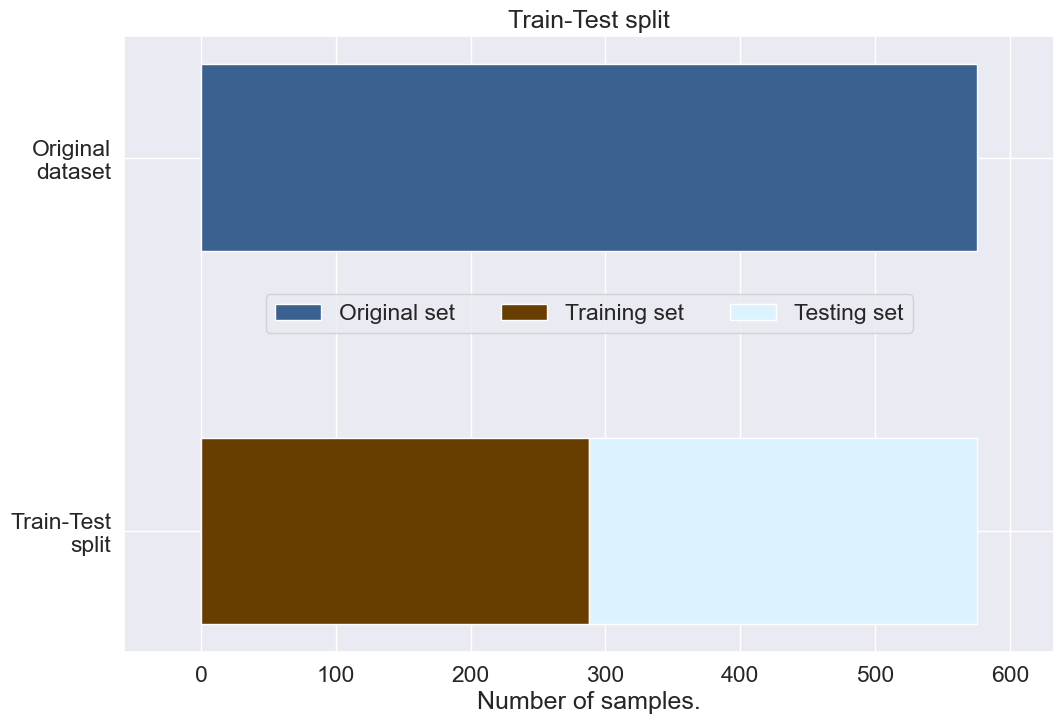

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

sns.set(font_scale=1.5)


def plot_simple_train_test(ax, all_dataset, train_set, test_set):
    """Create a sample plot for training-testing split."""
    bd_cmap = ["#3A6190", "#683E00", "#DDF2FF", "#2196F3"]

    ax.barh("Original\ndataset", len(all_dataset), left=0,
            height=0.5, color=bd_cmap[0])
    ax.barh("Train-Test\nsplit", len(train_set), left=0,
            height=0.5, color=bd_cmap[1])
    ax.barh("Train-Test\nsplit", len(test_set), left=len(train_set),
            height=0.5, color=bd_cmap[2])

    ax.invert_yaxis()
    ax.set(xlabel="Number of samples.", title="Train-Test split")
    ax.legend(["Original set", "Training set", "Testing set"], loc='lower center',
              ncols=4, bbox_to_anchor=(0.5, 0.5))
    ax.set_xlim([-int(0.1 * len(all_dataset)), int(1.1 * len(all_dataset))])
    return ax


fig, ax = plt.subplots(figsize=(12, 8))
plot_simple_train_test(ax=ax, all_dataset=windows_dataset,
                       train_set=train_set, test_set=test_set)

### 2. Train-Val-Test Split

This second option splits the original train_set into two distinct sets, the training set and the validation set to avoid overfitting the hyperparameters to the test set.

To split the train_set we will make use of the train_split argument of EEGClassifier. If you leave this empty (not None!), skorch will make an 80-20 train-validation split. If you want to control the split manually you can do that by using Subset from torch and predefined_split from skorch.

In [ ]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from skorch.helper import predefined_split, SliceDataset

X_train = SliceDataset(train_set, idx=0)
y_train = np.array([y for y in SliceDataset(train_set, idx=1)])
train_indices, val_indices = train_test_split(
    X_train.indices_, test_size=0.2, shuffle=False # shuffle ALWAYS should be false for time series
)
train_subset = Subset(train_set, train_indices)
val_subset = Subset(train_set, val_indices)

In [10]:
clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(val_subset),
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler("CosineAnnealingLR", T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
    max_epochs=n_epochs,
)
clf.fit(train_subset, y=None)

# evaluate the model after training and validation
y_test = test_set.get_metadata().target
test_acc = clf.score(test_set, y=y_test)
print(f"Test acc: {(test_acc * 100):.2f}%")

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2522       22.8018       0.2414            0.2414        6.0201  0.0006  0.2762
      2            0.2522       18.2534       0.2414            0.2414        6.0961  0.0000  0.2606
Test acc: 25.00%


### Visualization

<Axes: title={'center': 'Train-Test-Valid split'}, xlabel='Number of samples.'>

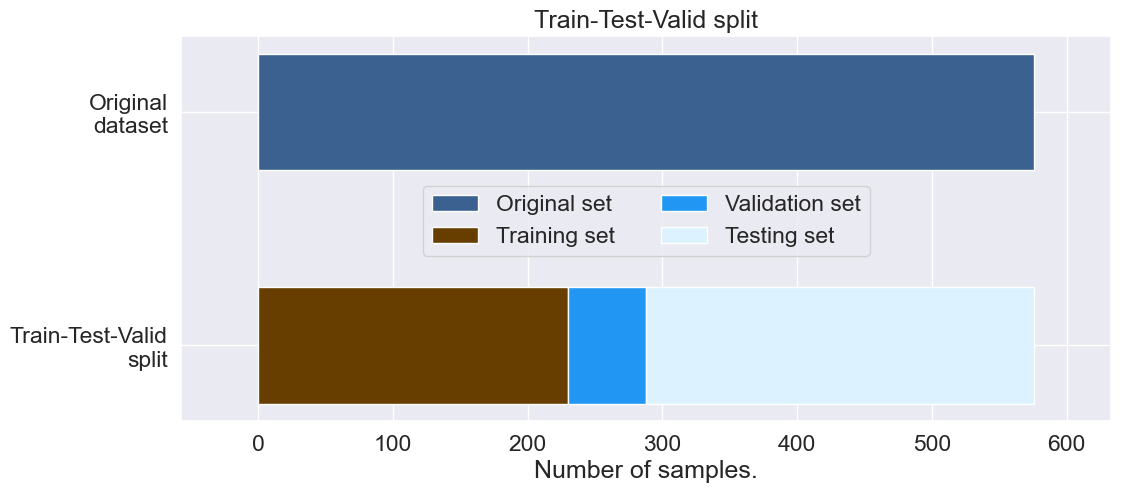

In [11]:
def plot_train_valid_test(ax, all_dataset, train_subset, val_subset, test_set):
    """Create a sample plot for training, validation, testing."""

    bd_cmap = ["#3A6190", "#683E00", "#2196F3", "#DDF2FF", ]

    n_train, n_val, n_test = len(train_subset), len(val_subset), len(test_set)
    ax.barh("Original\ndataset", len(all_dataset), left=0, height=0.5, color=bd_cmap[0])
    ax.barh("Train-Test-Valid\nsplit", n_train, left=0, height=0.5, color=bd_cmap[1])
    ax.barh("Train-Test-Valid\nsplit", n_val, left=n_train, height=0.5, color=bd_cmap[2])
    ax.barh("Train-Test-Valid\nsplit", n_test, left=n_train + n_val, height=0.5, color=bd_cmap[3])

    ax.invert_yaxis()
    ax.set(xlabel="Number of samples.", title="Train-Test-Valid split")
    ax.legend(["Original set", "Training set", "Validation set", "Testing set"],
              loc="lower center", ncols=2, bbox_to_anchor=(0.5, 0.4))
    ax.set_xlim([-int(0.1 * len(all_dataset)), int(1.1 * len(all_dataset))])
    return ax


fig, ax = plt.subplots(figsize=(12, 5))
plot_train_valid_test(ax=ax, all_dataset=windows_dataset,
                      train_subset=train_subset, val_subset=val_subset, test_set=test_set,)


### 3. k-Fold Cross Validation
As mentioned above, using only one validation split might not be sufficient, as there might be a shift in the data distribution. To compensate for this, one can run a k-fold Cross Validation, where every sample of the training set is in the validation set once. After averaging over the k validation scores afterwards, you get a very reliable estimate of how the model would perform on unseen data (test set).

To implement this, we will make use of sklearn function cross_val_score and the KFold. CV splitter. The train_split argument has to be set to None, as sklearn will take care of the splitting.

In [12]:
from skorch.callbacks import LRScheduler

from braindecode import EEGClassifier

from sklearn.model_selection import KFold, cross_val_score

lr = 0.0625 * 0.01
weight_decay = 0
batch_size = 64
n_epochs = 2

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler("CosineAnnealingLR", T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
    max_epochs=n_epochs,
)

train_val_split = KFold(n_splits=5, shuffle=False)
# By setting n_jobs=-1, cross-validation is performed
# with all the processors, in this case the output of the training
# process is not printed sequentially
cv_results = cross_val_score(
    clf, X_train, y_train, scoring="accuracy", cv=train_val_split, n_jobs=1
)
print(
    f"Validation accuracy: {np.mean(cv_results * 100):.2f}"
    f"+-{np.std(cv_results * 100):.2f}%"
)

  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.2522       19.8560  0.0006  0.2063
      2            0.2522       16.6040  0.0000  0.2210
  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.2478       19.3424  0.0006  0.2134
      2            0.2478       18.3361  0.0000  0.2136
  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.2609       17.2265  0.0006  0.2196
      2            0.2609       16.5518  0.0000  0.2157
  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.2597       18.7048  0.0006  0.2186
      2            0.2597       19.0092  0.0000  0.2136
  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------ 

<Axes: title={'center': 'KFold Train-Test-Valid split'}, xlabel='Number of samples.'>

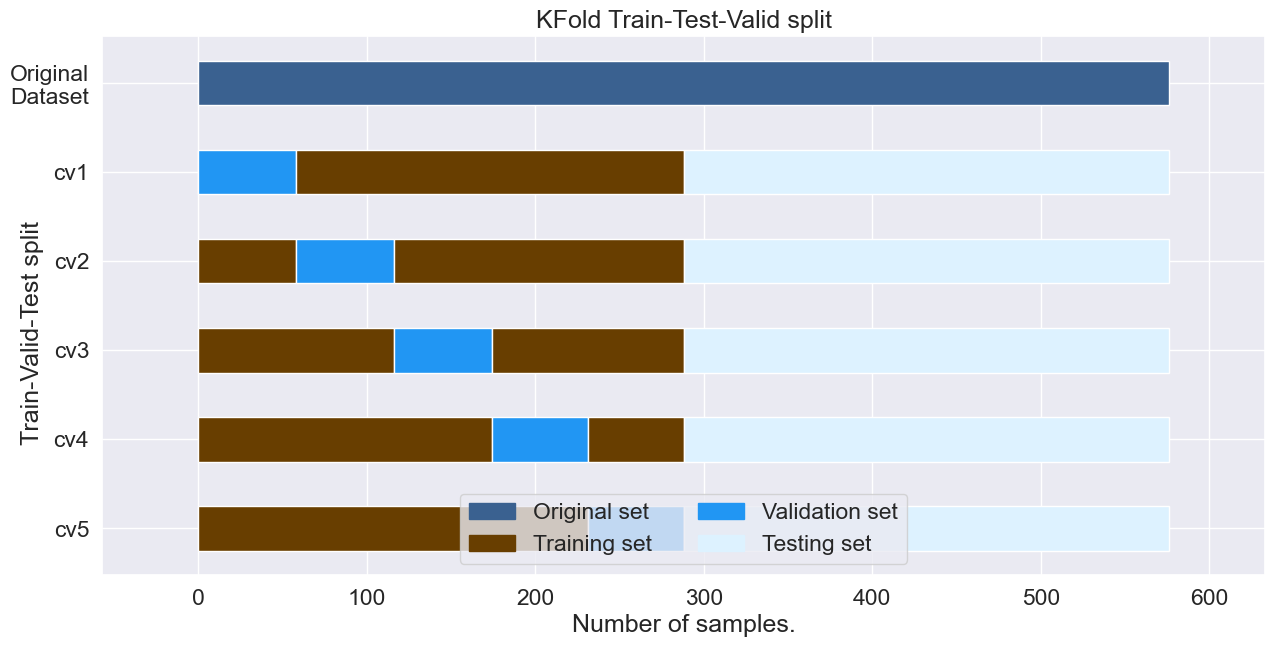

In [13]:
def plot_k_fold(ax, cv, all_dataset, X_train, y_train, test_set):
    """Create a sample plot for training, validation, testing."""

    bd_cmap = ["#3A6190", "#683E00", "#2196F3", "#DDF2FF", ]

    ax.barh("Original\nDataset", len(all_dataset), left=0, height=0.5, color=bd_cmap[0])

    # Generate the training/validation/testing data fraction visualizations for each CV split
    for ii, (tr_idx, val_idx) in enumerate(cv.split(X=X_train, y=y_train)):
        n_train, n_val, n_test = len(tr_idx), len(val_idx), len(test_set)
        n_train2 = n_train + n_val - max(val_idx) - 1
        ax.barh("cv" + str(ii + 1), min(val_idx), left=0, height=0.5, color=bd_cmap[1])
        ax.barh("cv" + str(ii + 1), n_val, left=min(val_idx), height=0.5, color=bd_cmap[2])
        ax.barh("cv" + str(ii + 1), n_train2, left=max(val_idx) + 1, height=0.5, color=bd_cmap[1])
        ax.barh("cv" + str(ii + 1), n_test, left=n_train + n_val, height=0.5, color=bd_cmap[3])

    ax.invert_yaxis()
    ax.set_xlim([-int(0.1 * len(all_dataset)), int(1.1 * len(all_dataset))])
    ax.set(xlabel="Number of samples.", title="KFold Train-Test-Valid split")
    ax.legend([Patch(color=bd_cmap[i]) for i in range(4)],
              ["Original set", "Training set", "Validation set", "Testing set"],
              loc="lower center", ncols=2)
    ax.text(-0.07, 0.45, 'Train-Valid-Test split', rotation=90,
            verticalalignment='center', horizontalalignment='left', transform=ax.transAxes)
    return ax


fig, ax = plt.subplots(figsize=(15, 7))
plot_k_fold(ax, cv=train_val_split, all_dataset=windows_dataset,
            X_train=X_train, y_train=y_train, test_set=test_set,)


## How to tune your hyperpaameters

### 1. Train-Val-Test Split

We will again make use of the sklearn library to do the hyperparameter search. GridSearchCV will perform a Grid Search over the parameters specified in param_grid. We use grid search for the model selection as a simple example, but you can use other strategies as well. (List of the sklearn classes for model selection.)

In [14]:
import pandas as pd
from sklearn.model_selection import GridSearchCV

train_val_split = [
    tuple(train_test_split(X_train.indices_, test_size=0.2, shuffle=False))
]

param_grid = {
    "optimizer__lr": [0.00625, 0.000625],
}

# By setting n_jobs=-1, grid search is performed
# with all the processors, in this case the output of the training
# process is not printed sequentially
search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=train_val_split,
    return_train_score=True,
    scoring="accuracy",
    refit=True,
    verbose=1,
    error_score="raise",
    n_jobs=1,
)

search.fit(X_train, y_train)
search_results = pd.DataFrame(search.cv_results_)

best_run = search_results[search_results["rank_test_score"] == 1].squeeze()

best_parameters = best_run["params"]

Fitting 1 folds for each of 2 candidates, totalling 2 fits
  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.2478       77.0690  0.0063  0.2439
      2            0.2478       87.7088  0.0000  0.2169
  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.2522       20.2782  0.0006  0.2080
      2            0.2522       17.5400  0.0000  0.2145
  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.2500       91.0703  0.0063  0.2874
      2            0.2500       93.6867  0.0000  0.2823


### 2. k-Fold Cross Validation
To perform a full k-Fold CV just replace train_val_split from above with the KFold cross-validator from sklearn.

In [15]:
train_val_split = KFold(n_splits=5, shuffle=False)